# Assignment 1. Greedy Heuristics
- Nikita Makarevich 153989
- Wojciech Mączka 148106

1. Source code - [GitHub](https://github.com/AmevinLS/evo-compute)
2. Results checked with solution checker - **YES**

## Problem Description


The Travelling Salesman Problem (TSP) is an NP-Hard problem of selecting a permutation of nodes of some graph $G$, such that the nodes form a Hamiltionian cycle, and the total length of the path plus the total cost of the included nodes is minimized. Additionaly in the version of the problem tackled in this work, it is required to choose at most $\lceil{\dfrac{N}{2}}\rceil$ nodes, where $N$ is the total number of nodes in the graph.

In this work we will tackle solving the TSP using the greedy aproaches.

## Pseudocode of algorithms

### 1. **Random**

```plaintext
function random is
    input: tsp instance T, final length of path N
    output: list of solutions

    solutions <- empty
    indices <- [0, 1, 2 ... len(T.nodes)]

    while len(solutions) < len(T.nodes) do
        shuffle(indices)
        solution <- cost: 0, path: indices[0..N]

        if solution.path in solutions do
            skip
        end if

        for i in range 0 .. path - 1 do
            solution.cost <- solution.cost
                + T.nodes[path[i]].weight
                + T.matrix(path[i], path[i + 1])
        end for

        solution.cost <- solution.cost
            + T.matrix(path[^1], path[0])
            + T.nodes(path[^1]).weight

        solutions <- solutions + solution
    end while
end function
```

### 2. **Nearest-neighbor at end of current path**
```plaintext
function nn_end is
    input: tsp instance T, final length of path N, start index I
    output: solution

    solution <- cost: T.nodes[I].weight, {I}

    while len(solution.path) < N do
        cur <- solution.path[^1]
        min_dist <- INFINITY
        min <- none

        for i in range 0 ... len(T.nodes) do
            if i == cur or i in solution.path do
                skip
            end if

            dist <- T.matrix(cur, i) + T.nodes[i].weight

            if dist < min_dist do
                min_dist <- dist
                min <- i
            end if
        end for

        solution.path <- solution.path + min
        solution.cost <- solution.cost
                        + T.nodes[min].weight
                        + min_dist        
    end while

    solution.cost <- solution.cost
        + T.matrix(solution.path[^1], solution.path[0])
end function
```

### 3. **Nearest-neighbor at any place in current path**
```plaintext
function nn_any is
    input: tsp instance T, final length of path N, start index I
    output: solution

    solution <- cost: T.nodes[I].weight, {I}

    while len(solution.path) < N do
        min, min_dist <- nn(T, solution, solution.path[0])
        idx <- 0

        for i in range 0 ... len(solution.path) - 1 do
            a <- solution.path[i]
            b <- solution.path[i + 1]

            for j in range 0 ... len(T.nodes.size()) do
                if (j in solution.path) do
                    skip
                end if

                dist <- T.nodes[j].weight + T.matrix(a, j) + T.matrix(j, b) - T.matrix(a, b)

                if (dist < min_dist) {
                    min_dist <- dist
                    min <- j
                    idx <- i + 1
                }
            end for
        end for
        
        last_min, dist <- nn(T, solution, solution.path[^1])

        if (dist < min_dist) do
            solution.path <- solution.path + last_min
            min_dist <- dist
        else do
            insert min into solution.path at idx
        end if

        solution.cost <- solution.cost
                        + min_dist        
    end while

    solution.cost <- solution.cost + T.matrix(solution.path[^1], solution.path[0])
end function
```

### 4. **Greedy Cycle**
```plaintext
function get_cost_diff is
    input: tsp instance T, list of nodes, new node, position
    output: cost difference

    pre_node <- nodes[position]
    
    if position == len(nodes) - 1 do
        post_node <- nodes[0]
    else
        post_node <- nodes[position + 1]
    end if

    return T.nodes[new_node].weight
           - T.adj_matrix[pre_node][post_node]
           + T.adj_matrix[pre_node][new_node]
           + T.adj_matrix[new_node][post_node]
end function

function run_greedy_cycle is
    input: tsp instance T, final length of path N, start node
    output: solution (path, cost)

    solution <- {cost: infinity, path: []}
    remaining_nodes <- set of all nodes in T

    // Select first 3 nodes "optimally"
    for i in remaining_nodes do
        for j in remaining_nodes do
            if i == j or i == start or j == start do
                continue
            end if

            candidate_cost <- T.nodes[i].weight
                              + T.nodes[j].weight
                              + T.nodes[start].weight
                              + T.adj_matrix[start][i]
                              + T.adj_matrix[i][j]
                              + T.adj_matrix[j][start]

            if candidate_cost < solution.cost do
                solution.path <- [start, i, j]
                solution.cost <- candidate_cost
            end if
        end for
    end for

    remove solution.path nodes from remaining_nodes

    // Select remaining nodes using GreedyCycle
    while len(solution.path) < N do
        min_diff <- infinity
        selected_node <- null
        idx <- 0

        for node in remaining_nodes do
            for i in range 0 to len(solution.path) - 1 do
                diff <- get_cost_diff(T, solution.path, node, i)

                if diff < min_diff do
                    min_diff <- diff
                    selected_node <- node
                    idx <- i
                end if
            end for
        end for

        insert selected_node at index idx + 1 in solution.path
        solution.cost <- solution.cost + min_diff
        remove selected_node from remaining_nodes
    end while

    return solution
end function
```

In [ ]:
# @title
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import logging

logging.basicConfig(level=logging.ERROR)

In [ ]:
# @title
def read_results(csv_path: str | Path) -> pd.DataFrame:
    df = pd.read_csv(csv_path)
    df["path"] = (
        df["path"].str.strip().str.split(" ").apply(lambda l: list(map(int, l)))
    )
    return df


def read_instance(csv_path: str | Path) -> pd.DataFrame:
    data = pd.read_csv(csv_path, sep=";", header=None)
    data.columns = ["x", "y", "value"]
    return data


def visualize_solution(tsp: pd.DataFrame, sol: list[int], ax: plt.Axes | None = None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(15, 7))

    sns.scatterplot(
        tsp,
        x="x",
        y="y",
        hue="value",
        size="value",
        ax=ax,
        palette="crest",
        legend=False,
        zorder=2,
    )
    edges_x = tsp.iloc[sol]["x"].to_list()
    edges_y = tsp.iloc[sol]["y"].to_list()

    for idx, x, y in zip(sol, edges_x, edges_y):
        ax.annotate(str(idx), (x + 0.5, y + 0.5))
    edges_x.append(edges_x[0]), edges_y.append(edges_y[0])
    ax.plot(edges_x, edges_y, c="red", zorder=1)
    return ax


tsp_to_df = {
    "TSPA": read_instance("./TSPA.csv"),
    "TSPB": read_instance("./TSPB.csv"),
}
algo_names = ["random", "nn_end", "nn_any", "greedy_cycle"]

dfs = []
for tsp_name in tsp_to_df:
    for algo_name in algo_names:
        data = read_results(f"./{tsp_name}_{algo_name}.csv")
        data["tsp_name"] = tsp_name
        data["algo_name"] = algo_name
        dfs.append(data)
results_df = pd.concat(dfs, axis=0)
results_df = results_df.set_index(["tsp_name", "algo_name"])

## Results of computational experiments

In [ ]:
results_df["cost"].groupby(["tsp_name", "algo_name"]).describe()[["mean", "min", "max"]]

mean       min       max
tsp_name algo_name                                   
TSPA     greedy_cycle   72633.940   71488.0   74410.0
         nn_any         73174.060   71179.0   75450.0
         nn_end         85108.510   83182.0   89433.0
         random        263358.085  232464.0  290895.0
TSPB     greedy_cycle   51386.010   49001.0   57262.0
         nn_any         45870.255   44417.0   53438.0
         nn_end         54390.430   52319.0   59030.0
         random        214233.600  194171.0  231996.0

## Best Result Visualizations

<ipython-input-10-ec52bdccfb0e>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]
<ipython-input-10-ec52bdccfb0e>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]
<ipython-input-10-ec52bdccfb0e>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]
<ipython-input-10-ec52bdccfb0e>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]
<ipython-input-10-ec52bdccfb0e>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]
<ipython-input-10-ec52bdccfb0e>:13: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]
<ipython-input-1

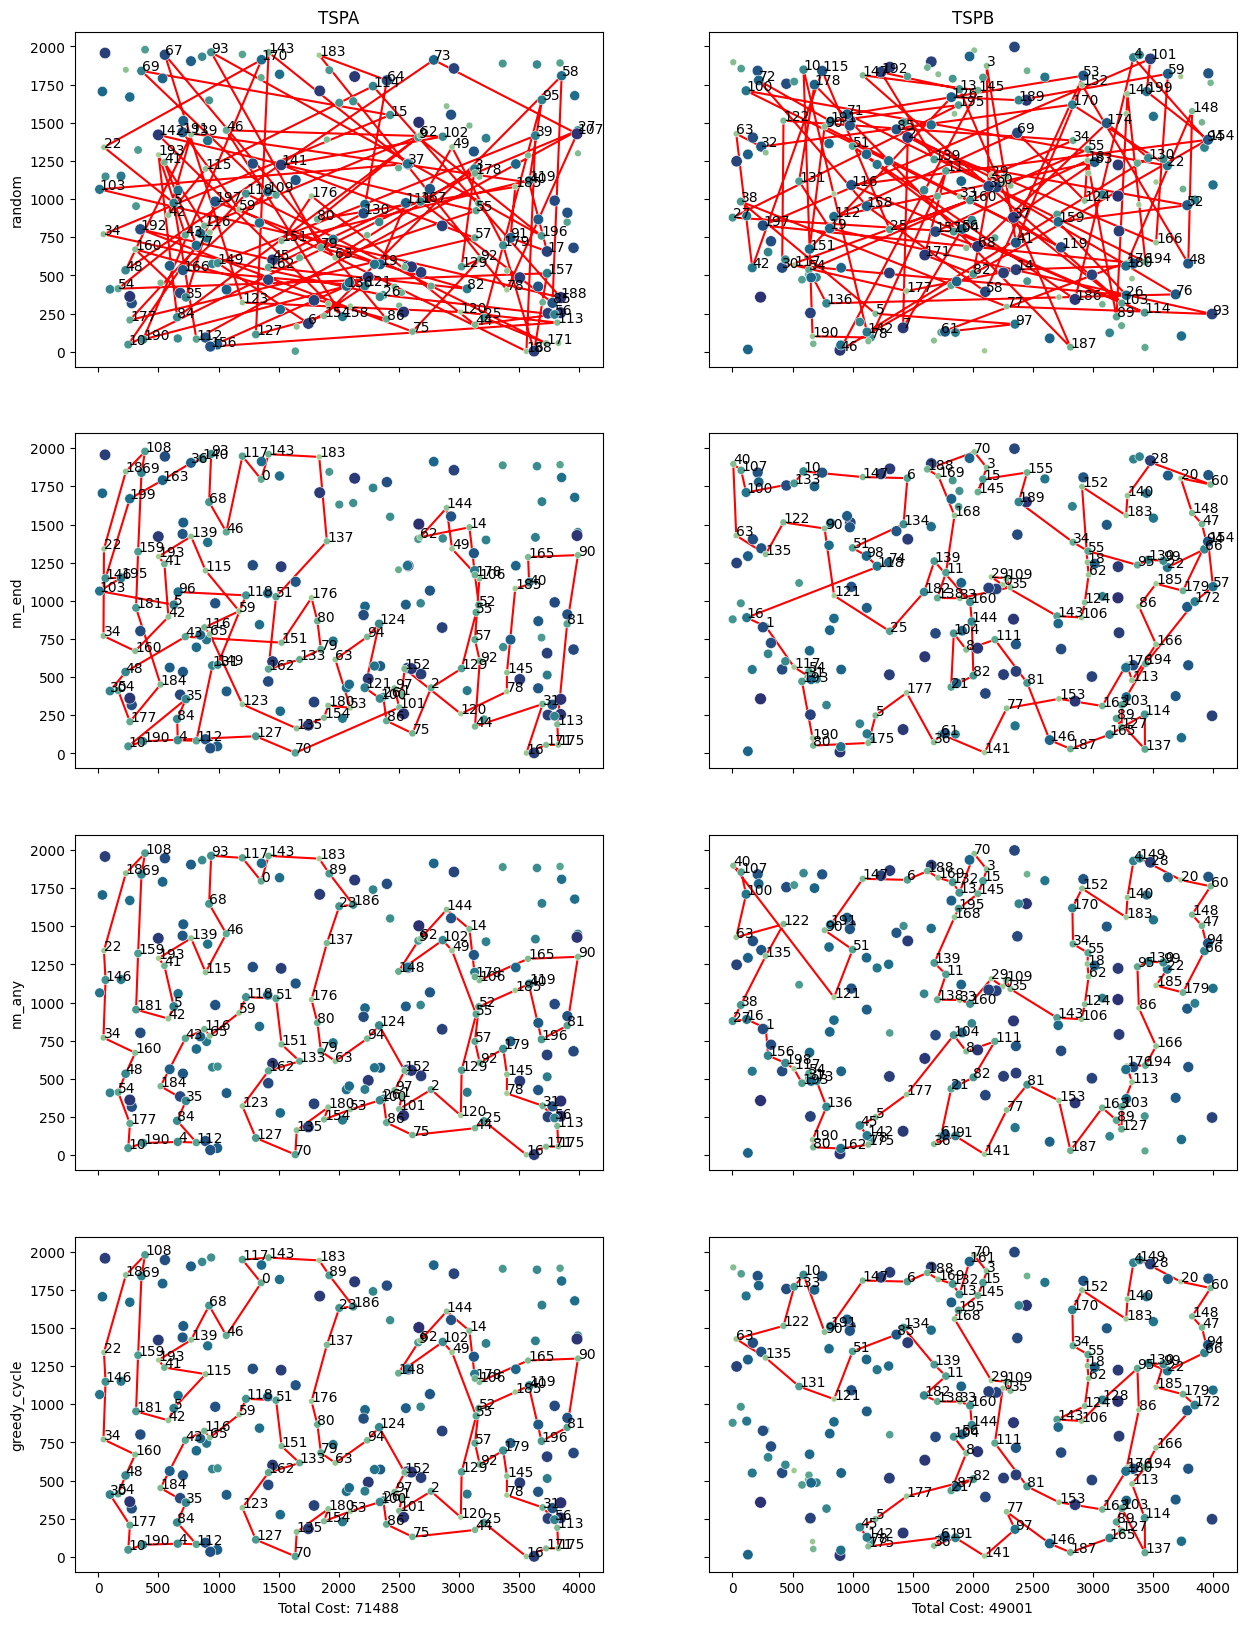

In [ ]:
# @title
fig, axs = plt.subplots(
    len(algo_names),
    len(tsp_to_df),
    figsize=(15, 5 * len(algo_names)),
    sharex=True,
    sharey=True,
)
axs = axs.reshape((len(algo_names), len(tsp_to_df)))

for i, tsp_name in enumerate(tsp_to_df.keys()):
    for j, algo_name in enumerate(algo_names):
        candidates_df = results_df.loc[(tsp_name, algo_name)]
        best_idx = np.argmin(candidates_df["cost"])

        ax = axs[j, i]
        visualize_solution(
            tsp_to_df[tsp_name], candidates_df.iloc[best_idx]["path"], ax=ax
        )
        if j == 0:
            ax.set_title(tsp_name)
        if i == 0:
            ax.set_ylabel(algo_name)
        ax.set_xlabel(f"Total Cost: {candidates_df.iloc[best_idx]['cost']}")

## Best solutions

In [ ]:
# @title
for i, tsp_name in enumerate(tsp_to_df.keys()):
    for j, algo_name in enumerate(algo_names):
        candidates_df = results_df.loc[(tsp_name, algo_name)]
        best_idx = np.argmin(candidates_df["cost"])
        print(
            f"{tsp_name} | {algo_name}: {candidates_df.iloc[best_idx]['cost']}",
        )
        for val in candidates_df.iloc[best_idx]["path"]:
            print(val, end=", ")
        print("\n\n")

<ipython-input-5-e0324528c694>:4: PerformanceWarning: indexing past lexsort depth may impact performance.
  candidates_df = results_df.loc[(tsp_name, algo_name)]


TSPA | random: 232464
142, 55, 63, 3, 129, 92, 75, 192, 45, 130, 64, 183, 78, 107, 73, 48, 139, 42, 115, 114, 188, 103, 37, 143, 127, 154, 58, 85, 167, 49, 179, 88, 157, 54, 43, 193, 84, 9, 196, 93, 79, 82, 162, 111, 19, 197, 35, 160, 86, 67, 123, 120, 113, 156, 136, 190, 170, 22, 5, 112, 27, 178, 10, 77, 41, 116, 62, 80, 185, 91, 17, 40, 191, 59, 16, 39, 149, 6, 121, 166, 109, 69, 15, 34, 26, 56, 44, 176, 151, 119, 95, 25, 171, 118, 177, 57, 141, 102, 46, 158, 


TSPA | nn_any: 71179
68, 46, 115, 139, 193, 41, 5, 42, 181, 159, 69, 108, 18, 22, 146, 34, 160, 48, 54, 177, 10, 190, 4, 112, 84, 35, 184, 43, 116, 65, 59, 118, 51, 151, 133, 162, 123, 127, 70, 135, 180, 154, 53, 100, 26, 86, 75, 44, 25, 16, 171, 175, 113, 56, 31, 78, 145, 179, 92, 57, 52, 185, 119, 40, 196, 81, 90, 165, 106, 178, 14, 144, 62, 9, 148, 102, 49, 55, 129, 120, 2, 101, 1, 97, 152, 124, 94, 63, 79, 80, 176, 137, 23, 186, 89, 183, 143, 0, 117, 93, 


TSPA | nn_end: 83182
124, 94, 63, 53, 180, 154, 135, 123, 65, 116

## Conclusions

In conclusion, the results turned out being rather non-suprising, as with the increasing complexity of the heuristics, all performance metrics (min, max, avg) decreased. Random walk method turned out to be the worst heuristic by a large margin, and the simplest of the greedy methods, NN with appending, was on average almost 4 times better. Greedy Cycle and NN with insert yielded comparable results, however the latter was noticably less performant. Finally, the visualizations proved to be predictable as well, as the simpler methods produces far less aesthetic graphs.